In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime
from itertools import product #数学类的函数 笛卡爾
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [2]:
#讀取數據
df=pd.read_csv('shanghai_1990-12-19_to_2019-2-28.csv')

In [3]:
#將時間作為df索引
df.Timestamp=pd.to_datetime(df.Timestamp)
df.index=df.Timestamp

In [4]:
#數據探索
df.head()

,Timestamp,Price
Timestamp,,
1990-12-19,1990-12-19,96.05
1990-12-20,1990-12-20,104.30
1990-12-21,1990-12-21,109.07
1990-12-24,1990-12-24,113.57
1990-12-25,1990-12-25,120.09


In [5]:
#按照月,季度,年來統計
#resample()进行重采样
df_month=df.resample('M').mean() #月
df_Q=df.resample('Q-DEC').mean() #季度
df_year=df.resample('A-DEC').mean() #年

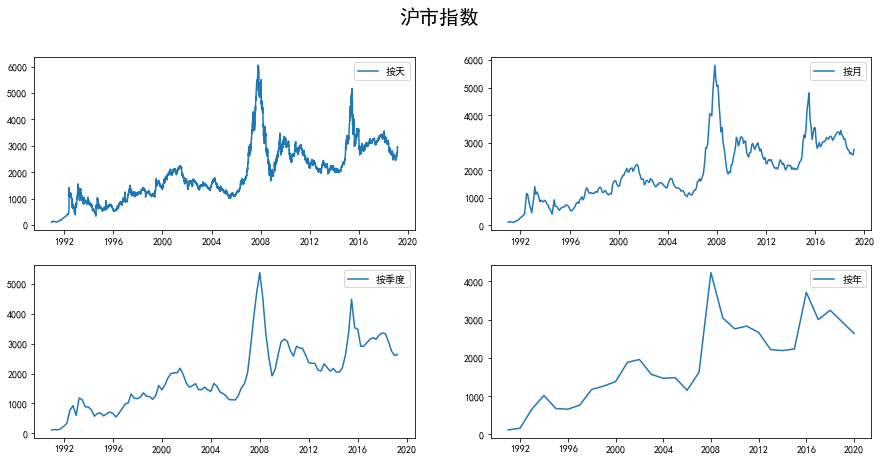

In [7]:
#按照天,月,季度,年來顯示沪市指数的走勢
fig=plt.figure(figsize=[15,7]) #設置畫布寬15高7
plt.suptitle('沪市指数',fontsize=20) #主標題

plt.subplot(221)  # 分成2x2，佔用第一個，即第一行第一列的子圖
plt.plot(df.Price,'-',label='按天') #繪製按天平均走勢圖
plt.legend()#展示每个数据对应的图像名称

plt.subplot(222)
plt.plot(df_month.Price,'-',label='按月')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Price,'-',label='按季度')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Price,'-',label='按年')
plt.legend()
plt.show()

In [10]:
#設置參數範圍
#p 和 q 的值，也就是 ARMA 中的阶数
ps=range(0,5)
qs=range(0,5)
parameters=product(ps,qs)
parameters_list=list(parameters)

In [12]:
#尋找最優ARMA模型參數,即best_aic最小
results=[]
best_aic=float('inf')#正無窮

for param in parameters_list:
    try:
        model=ARMA(df_month.Price,order=[param[0],param[1]]).fit()
    except ValueError:
        print('參數錯誤',param)
        continue
    aic=model.aic #AIC数值越小代表模型拟合得越好
    if aic<best_aic:
        best_model=model
        best_aic=aic
        best_param=param
    results.append([param,model.aic])#最優參數
#輸出最優模型
result_table=pd.DataFrame(results)
result_table.columns=['parameters','aic']
print('最優模型:',best_model.summary())

參數錯誤 (0, 2)
參數錯誤 (0, 3)
參數錯誤 (0, 4)
最優模型:                               ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  339
Model:                     ARMA(4, 3)   Log Likelihood               -2199.934
Method:                       css-mle   S.D. of innovations            158.171
Date:                Sun, 20 Sep 2020   AIC                           4417.867
Time:                        17:10:34   BIC                           4452.301
Sample:                    12-31-1990   HQIC                          4431.589
                         - 02-28-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1870.6178    398.926      4.689      0.000    1088.737    2652.499
ar.L1.Price     1.5014      0.127     11.801      0.000       1.252       1.751
ar.L2.

In [15]:
#沪市指数預測
df_month2=df_month[['Price']]#選中每日價格
date_list=[datetime(2019,3,31),datetime(2019,4,30),#設置需要預測的時間
           datetime(2019,5,31),datetime(2019,6,30),datetime(2019,7,31),
           datetime(2019,8,31),datetime(2019,9,30),datetime(2019,10,31)]
future=pd.DataFrame(index=date_list,columns=df_month.columns) #設置表格格式
df_month2=pd.concat([df_month2,future]) #默認直向合併表格
#1990-12-19到2019-2-28有348個月
df_month2['forecast']=best_model.predict(start=0,end=348)

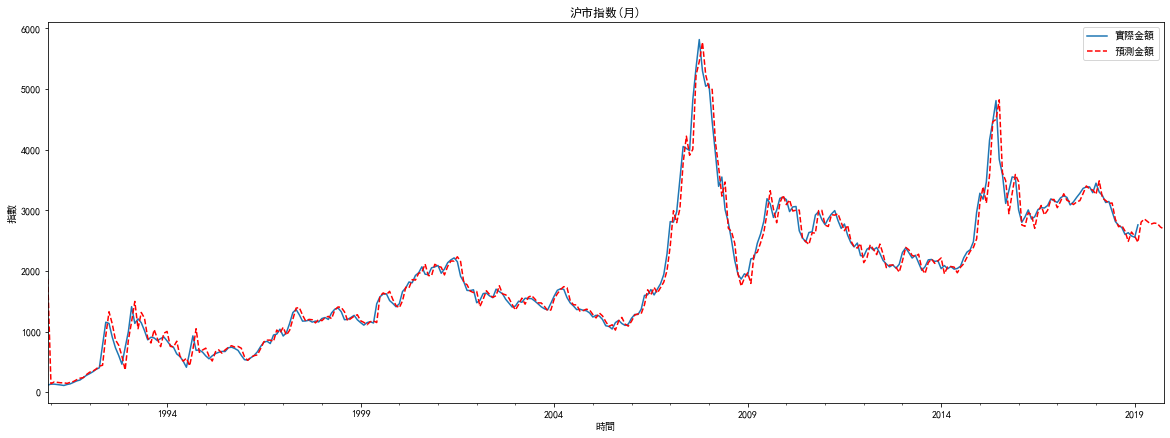

In [16]:
#比特幣預測結果顯示
plt.figure(figsize=(20,7))
df_month2.Price.plot(label='實際金額')
df_month2.forecast.plot(color='r',ls='--',label='預測金額')
plt.legend()
plt.title('沪市指数(月)')
plt.xlabel('時間')
plt.ylabel('指數')
plt.show()